# Semi Parammetric Latent Factor Model

###  $Y=\phi * u + \sigma^2I$
##### Where, $\phi \in R ^{cxp}, u \in R^{pxn}$ and $Y \in R^{cxn}$
##### Also, $u_p \in GP(0,K^p)$ where $K^p$ is the covariance kernel for that particular gaussian process


In [1]:
### necessary Imports
import numpy as np
import pylab as pb
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as MNormalDist
import GPy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### True Model:

Here we generate our data that we can later use to check our solution

#### $\phi \in N(0,I)$

#### $u$
First we have similar kernels so that processes can be easily distinguished
We choose one as a exponential quad Kernel with shorter length scale.

Phi
[[-0.71604512 -0.53503342  1.72501184]
 [ 0.84640445 -0.05235883  0.08416679]
 [-1.18886183  0.16720076  1.66604975]
 [ 1.23722536 -1.09752519 -0.19173606]]


<matplotlib.colorbar.Colorbar instance at 0x7fc96e4f59e0>

 /usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


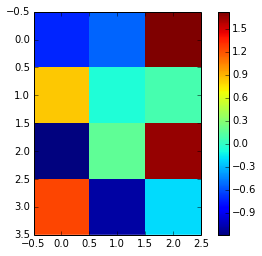

In [2]:
P = 3
C = 4
N = 100
s2 = 0.5
x = np.linspace(0,N-1,N)
phi = np.random.normal(loc=0,scale=1,size=(C,P))
print "Phi\n",phi
plt.imshow(phi,interpolation='none')
plt.colorbar()

### Kernel classes to be used to generate differnet Kernels for latent processes
#### We keep one with high and one low length scale to distinguish between them easily

In [3]:
class Kernel:
    @staticmethod
    def fetchParams(intializations,passed):
        params ={}
        for param in intializations:
            if param in passed:
                params[param] = passed[param]
            else:
                params[param] = intializations[param]
        return params
    
    @staticmethod
    def exponenQuad(x,xprime,a=1,l=0.5,**kwargs):
        if kwargs:
            if kwargs['a']:
                a = kwargs['a']
            if kwargs['l']:
                l = kwargs['l'] 
        return a*np.exp((-0.5*(x - xprime)**2)/l**2)
    
    @staticmethod
    def periodic(x,xprime,**kwargs):
        initializations = { 'a':1,
                            'p':0.5,
                            'l':0.5}
        params = Kernel.fetchParams(initializations,kwargs)
        return params['a']*np.exp((-2*np.sin(np.pi* np.abs(x - xprime)/(params['p']))**2)/(params['l']**2))
        
    @staticmethod
    def linear(x,xprime,**kwargs):
        initializations = { 'a': 0.3}
        params = Kernel.fetchParams(initializations,kwargs)
        return params['a']*(x*xprime)
    
    @staticmethod
    def generateKernel(kernelFunc,x,xprime,**kwargs):
        kernel = np.zeros((x.size,xprime.size))
        for i in range(x.size):
            for j in range(xprime.size):
                kernel[i,j] = kernelFunc(x[i],xprime[j],**kwargs)
        return np.mat(kernel)

<matplotlib.colorbar.Colorbar instance at 0x7fc96e154dd0>

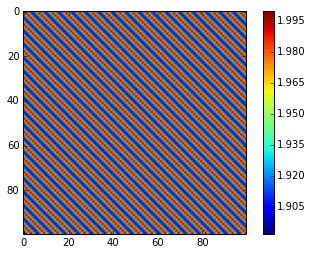

In [4]:
K = list()
K.append(Kernel.generateKernel(Kernel.periodic,x,x,a=2,l=6,p=6))
K.append(Kernel.generateKernel(Kernel.linear,x,x,a=0.005))
K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=3))
#K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=2))
#K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=1))
imshow(K[0],interpolation=None)       
plt.colorbar()

 /home/nautiys1/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning:covariance is not positive-semidefinite.


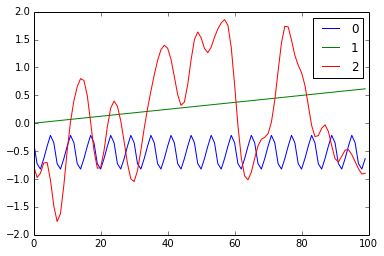

In [5]:
#Latent Gaussian Processes:
u = np.zeros((P,N))
for p in range(P):
    u[p,:] = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=K[p])
    plt.plot(u[p,:],label=p)
plt.legend()

#### Generate data :


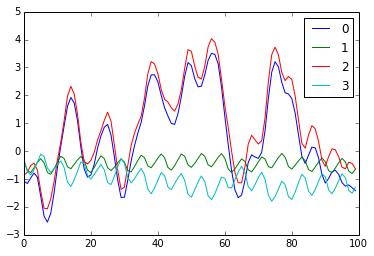

In [7]:
# Output Values:
s2 = 0
Y = phi.dot(u) + s2
for c in range(C):
    plt.plot(Y[c,:],label=c)
plt.legend()

## Now objective is to variationally approximate and recover Phi 

Variational Inducing Updates are:


### Intialization for variational updaes

- Select random inducing points {Needs to be optimized later}
- Generate Kernels 
- Phi Prior: N(0,I)
- uHatMeans Just random PXn values sampled form N(0,1) 
- uExp: Just random PXN values sampled form N(0,1)

In [30]:
class SLFM:
    
    def __init__(self,Y,P,KernelFuncs=[]):
        self.Y = Y
        self.P = P
        self.C,self.N = Y.shape
        self.s2 = 0.5
        self.x = np.linspace(0,N-1,N)
        self.phi = np.random.normal(loc=0,scale=1,size=(C,P))
        if len(KernelFuncs) < self.P:
            self.KernelFuncs = SLFM.__generateRBFKernelFuncs(self.P)
    
    @staticmethod
    def __generateRBFKernelFuncs(P):
        kernels = []
        for p in range(P):
            kernels.append(Kernel.exponenQuad)
        return kernels
            
    def induced_variation_fit(n,optimizeInduction=False):
        self.noOfInductions = n
        if optimizeInduction:
            self.optimizeInduction()
        else:
            self.prepSparseVariationInference()
    
    ## Intialization for variational inference
    def prepSparseVariationInference(self,noOfInductions):
        self.n = sort(np.random.choice(self.x,size=noOfInductions,replace=False))
        # Create Matrices
        self.Knn = list()
        self.KNn = list()
        self.KnnInv = list()
        self.KNN = list()
        for i in range(P):
            self.Knn.append(Kernel.generateKernel(Kernel.exponenQuad,self.n,self.n,l=3,a=4))
            self.KNn.append(Kernel.generateKernel(Kernel.exponenQuad,self.x,self.n,l=3,a=4))
            self.KNN.append(Kernel.generateKernel(Kernel.exponenQuad,self.x,self.x,l=3,a=4))
            self.KnnInv.append(np.linalg.inv(self.Knn[i]))
        # Generate a guess for phi
        self.phiHatMean = 0
        self.phiHatV = 1
        self.phiHatExp = np.mat(np.random.normal(loc=self.phiHatMean,scale=self.phiHatV,size=(C,P)))
        #phiHatExp = phi
        self.phiHatVar = np.eye(P)
        self.uHatMeans = np.random.normal(loc=0,scale=1,size=(P,noOfInductions,1))
        self.uExp = np.random.normal(loc=0,scale=1,size=(P,N))
        self.uHatVs = list()
        self.uVar = list()
        self.Ups = list()
        self.Zps = list()
        self.initializeAll(noOfInductions)
    
    
    def initializeAll(self,noOfInductions):
        for p in range(self.P):
            Up,Zp = self.calculateUpZp(p)
            self.Ups.append(Up)
            self.Zps.append(Zp)
            self.uHatVs.append(np.eye(noOfInductions))
            self.uVar.append(np.eye(N))
            
    def calculateUpZp(self,p):
        #Find Up and Zp
        excludeP = np.arange(self.P)!=p
        #print i,p
        Zp = self.phiHatExp[:,p].T.dot(self.Y - self.phiHatExp[:,excludeP]*self.uExp[excludeP,:])
        phiSqHatExp = self.C*self.phiHatVar[p,p] + self.phiHatExp[:,p].T.dot(self.phiHatExp[:,p])
        Up = np.diagflat(np.multiply(np.ones(N) ,phiSqHatExp))
        return Up,Zp
            
    
    def displayGPs(self,gps,gpVars=None,ax=None):
        if ax == None:
            ax = plt
        for i in range(len(gps)):
            gp = gps[i]
            ax.plot(gp,label=i)
            if gpVars is not None:
                std = np.sqrt(np.diag(gpVars[i]))
                ax.fill_between(self.x,gp-std,gp+ std, alpha = 0.1,color='cyan')
        plt.legend()
        plt.show()
    
    def displayGuesses(self):
        fig,axes = plt.subplots(nrows = 1,ncols = 2, figsize=(18,8))
        im = axes[0].imshow(self.phiHatExp,interpolation='None')
        plt.colorbar(im,ax=axes[0])
        axes[0].set_title("Phi")
        for p in range(P):
            gp = self.uExp[p]
            axes[1].plot(self.x,gp)
            axes[1].set_title("Latent Process Guess")
            std = np.sqrt(np.diag(self.uVar[p]))
            axes[1].fill_between(self.x,gp-std,gp+ std, alpha = 0.2,color='cyan')
    
    def calculateLikelihood(self,p):
        uInv = np.linalg.inv(self.Ups[p])
        covMul = self.KNn[p]*self.KnnInv[p]*self.KNn[p].T
        logNterm = sum(MNormalDist.logpdf(x=uInv*self.Zps[p].T, mean=  np.zeros((self.N)),cov=uInv +covMul )) 
        summationForTrace = np.zeros((N,N))
        for i in range(P):
            covUiHat = self.KNN[i] - self.KNn[i]*self.KnnInv[i]*self.KNn[i].T
            summationForTrace += self.Ups[i]*covUiHat
        likl = logNterm - 0.5*np.matrix.trace(summationForTrace) 
        return likl
    
    def calculateTotalLikelihood(self):
        return sum([self.calculateLikelihood(p) for p in range(P)])
    
    
    def variation_fit(self):
        prevLikl = slfm.calculateTotalLikelihood()
        newLikl = 0
        while(abs(newLikl - prevLikl) > 0.002):
            #Updates for u's
            for p in range(P):
                Up,Zp = self.calculateUpZp(p)
                ###Update Up,Zp
                self.Ups[p] = Up
                self.Zps[p] = Zp
                KNKnInv = self.KNn[p]*self.KnnInv[p]
                SigmaP = self.KnnInv[p] + KNKnInv.T * Up *KNKnInv
                self.uHatMeans[p] = np.linalg.inv(SigmaP)*KNKnInv.T*Zp.T
                self.uExp[p] = (KNKnInv*self.uHatMeans[p]).reshape(1,N)
                SigmaUGvUp = self.KNN[p] - KNKnInv * self.KNn[p].T
                self.uVar[p] = SigmaUGvUp + KNKnInv*SigmaP*KNKnInv.T
            #Update Phi
            ## Variational Update for Phi
            Vf= self.uExp.dot(self.uExp.T)
            SigmaPhi = np.linalg.inv(Vf + np.eye(self.P))
            self.phiHatExp = np.mat(self.Y) * self.uExp.T * SigmaPhi
            self.phiHatVar = SigmaPhi
            #Find new likl
            if newLikl != 0:
                prevLikl = newLikl
            newLikl = self.calculateTotalLikelihood()
            #print abs(newLikl - prevLikl)

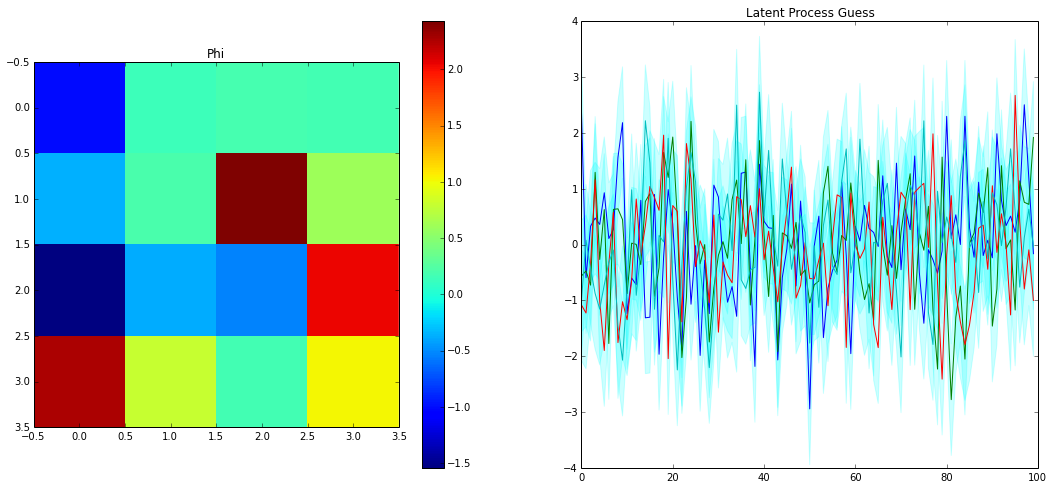

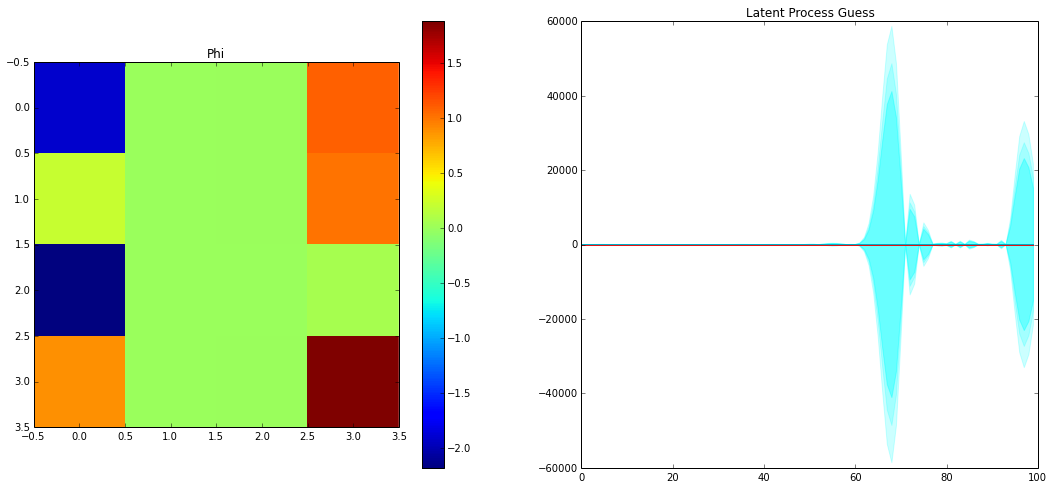

In [31]:
slfm = SLFM(Y,P)
slfm.prepSparseVariationInference(30)
slfm.displayGuesses()
plt.show()
slfm.variation_fit()
slfm.displayGuesses()

In [32]:
## get random inducing point
## Intialization for variational inference
P=4
noOfInductions = 70
n = sort(np.random.choice(x,size=noOfInductions,replace=False))
sparseY = np.mat(Y[:,n.astype(int)])
# Create Matrices
Knn = list()
KNn = list()
KnnInv = list()
KNN = list()
for i in range(P):
    Knn.append(Kernel.generateKernel(Kernel.exponenQuad,n,n,l=3,a=4))
    KNn.append(Kernel.generateKernel(Kernel.exponenQuad,x,n,l=3,a=4))
    KNN.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=3,a=4))
    KnnInv.append(np.linalg.inv(Knn[i]))
    print KNn[i].shape,Knn[i].shape,KnnInv[i].shape
# Generate a guess for phi
phiHatMean = 0
phiHatV = 1
phiHatExp = np.mat(np.random.normal(loc=phiHatMean,scale=phiHatV,size=(C,P)))
#phiHatExp = phi
phiHatVar = np.eye(P)
uHatMeans = np.random.normal(loc=0,scale=1,size=(P,noOfInductions,1))
uHatVs = [np.eye(noOfInductions)for p in range(P)]
uExp = np.random.normal(loc=0,scale=1,size=(P,N))
uVar = list()
Ups = [np.eye(N) for p in range(P)]
Zps = [np.zeros(N) for p in range(P)]


(100, 70) (70, 70) (70, 70)
(100, 70) (70, 70) (70, 70)
(100, 70) (70, 70) (70, 70)
(100, 70) (70, 70) (70, 70)


### Initial Guesses:
    

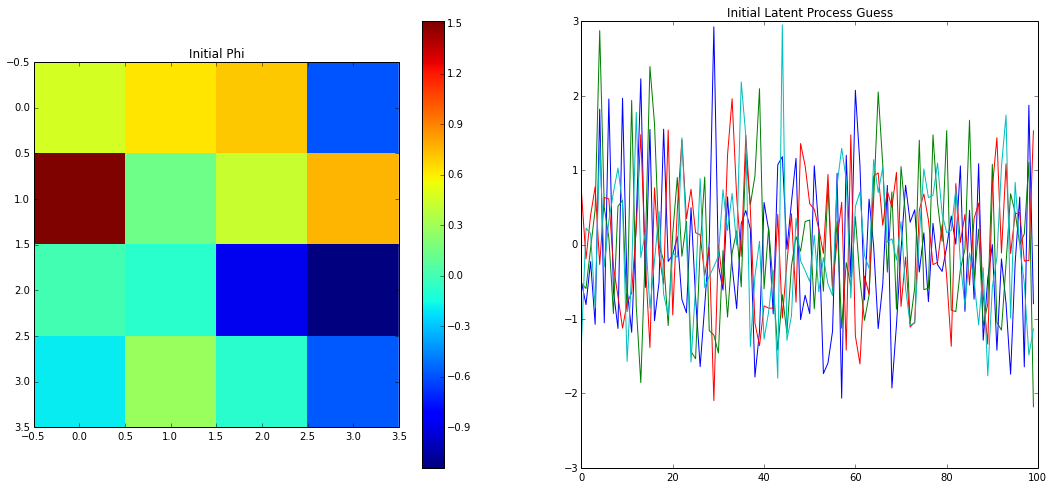

In [33]:
def displayGuesses(phiHatExp,uExp):
    fig,axes = plt.subplots(nrows = 1,ncols = 2, figsize=(18,8))
    im = axes[0].imshow(phiHatExp,interpolation='None')
    plt.colorbar(im,ax=axes[0])
    axes[0].set_title("Initial Phi")

    for p in range(P):
        
        axes[1].plot(x,uExp[p])
        axes[1].set_title("Initial Latent Process Guess")
displayGuesses(phiHatExp,uExp)

### Variational Updates are:

#### For U's:

$q(\hat{u}_p) \propto N(\Sigma_{p}^{-1}K_{n}^{-1}K_{Nn}Z_p,\Sigma_{p})$
where $\Sigma_{p} = K_{n}^{-1} + \frac{1}{\sigma^2}K_{n}^{-1}K_{nN}F_pK_{Nn}K_{n}^{-1}$


and $Z_p = \sum_{c}^{C}<\phi_{cp}>(y_c - \sum_{i}^{P/p}<\phi_{ci}><u_{ip}>)$, 
and $F_p = \sum_{c}^{C}<\phi_{cp}^2>$

$<\phi_{cp}^2> = var(\phi_{cp}) - <\phi_{cp}>^2$ 


Also,Actual U is:

${q(u) \propto N (K_{Nn}K_{n}^{-1}\hat{\mu}_{p}, \Sigma_{u|u^{p}} + M\Sigma_{p}M^{T})}$


where $\hat{\mu}_{p}$ is the mean of $\hat{u}_p$

and  $\Sigma_{u|u^{p}} = K_{N} - K_{Nn}K_{n}^{-1}K_{nN}$ , $M = K_{Nn}K_{n}^{-1}$

#### For $\phi$:

$$\phi = N(yU^{T}\Sigma_{\phi}^{-1}, \Sigma_{\phi}^{-1})$$
where $\Sigma_{\phi} = (V_{\phi} + I )$
and $V_{\phi} = <U><U>^T\sigma^2$

### And lower bound of liklelihood with respect to $u_p$ is given by:

$L(u_p) = log N(F_{p}^{-1}z_p| 0, F_{p}^{-1} + K_{Nn}K_{nn}^{-1}K_{nN}) - \frac{1}{2}tr(\sum_{i}^{P}{U_i*cov(u_i|\hat{u_i}}))$ - KL divergence terms.. 

where
$ cov(u_p|\hat{u}_p) = K_N - K_{Nn}K_{n}^{-1}K_{nN}$




In [10]:
#Calculate likelihood ofr single Up
def calculateLikelihood(p):
    uInv = np.linalg.inv(Ups[p])
    covMul = KNn[p]*KnnInv[p]*KNn[p].T
    logNterm = sum(MNormalDist.logpdf(x=uInv*Zps[p].T, mean=  np.zeros((N)),cov=uInv +covMul )) 
    summationForTrace = np.zeros((N,N))
    for i in range(P):
        covUiHat = KNN[i] - KNn[i]*KnnInv[i]*KNn[i].T
        summationForTrace += Ups[i]*covUiHat
    likl = logNterm - 0.5*np.matrix.trace(summationForTrace) 
    return likl

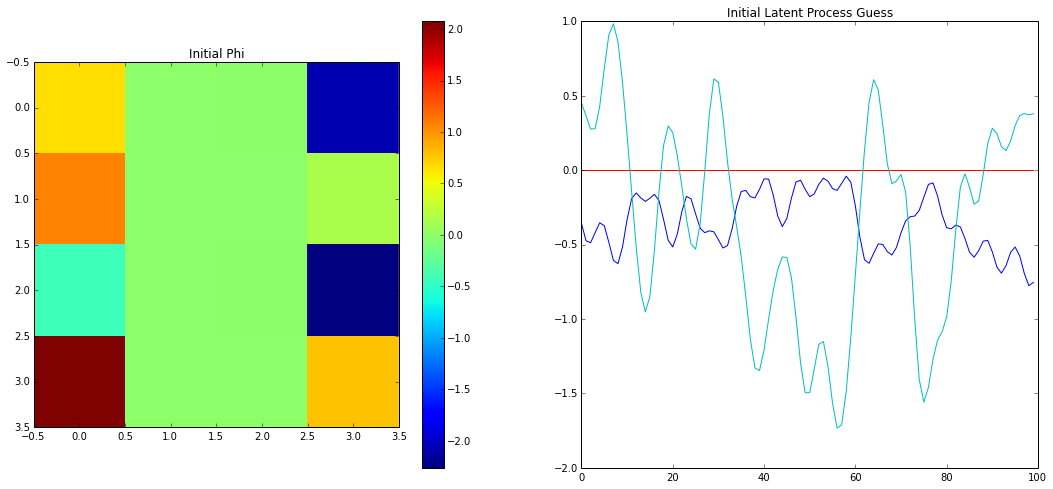

In [34]:
likelihoods = list()
for i in range(100):
    #Variational Update for Up:
    likl = list()
    for p in range(P):
        #Find Up and Zp
        excludeP = np.arange(P)!=p
        #print i,p
        Zp = (phiHatExp[:,p].T.dot(Y - phiHatExp[:,excludeP]*uExp[excludeP,:])).reshape(1,N)
        phiSqHatExp = C*phiHatVar[p,p] + phiHatExp[:,p].T.dot(phiHatExp[:,p])
        Up = np.diagflat(np.multiply(np.ones(N) ,phiSqHatExp))
        Ups[p] = Up
        Zps[p] = Zp
        KNKnInv = KNn[p]*KnnInv[p]
        SigmaP = KnnInv[p] + KNKnInv.T * Up *KNKnInv
        uHatMeans[p] = (np.linalg.inv(SigmaP)*KNKnInv.T*Zp.T).reshape(noOfInductions,1)
        uExp[p] = (KNKnInv*uHatMeans[p]).reshape(1,N)
        SigmaUGvUp = KNN[p] - KNKnInv * KNn[p].T
        uVar.append(SigmaUGvUp + KNKnInv*SigmaP*KNKnInv.T)
        #likl.append(calculateLikelihood(p))
    ## Variational Update for Phi
    Vf= uExp.dot(uExp.T)
    SigmaPhi = np.linalg.inv(Vf + np.eye(P))
    phiHatExp = np.mat(Y) * uExp.T * SigmaPhi
    phiHatVar = SigmaPhi
    likelihoods.append(calculateLikelihood(p))
    #likelihoods.append(likl)
displayGuesses(uExp=uExp,phiHatExp=phiHatExp)

## Reconstruct the data :

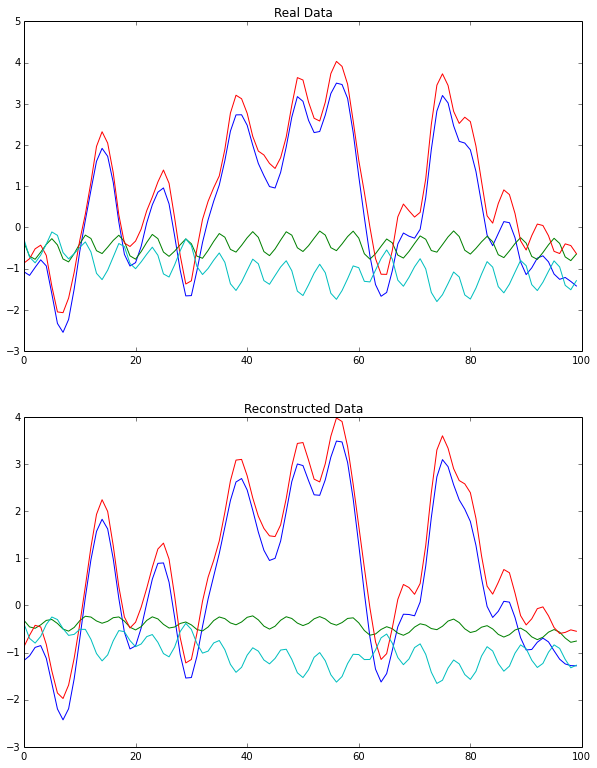

In [24]:
Ynew = phiHatExp * uExp
fig,axes = plt.subplots(nrows=2,ncols = 1,figsize=(10,13))
axes[0].plot(Y.T)
axes[0].set_title('Real Data')
#axes[0].scatter(n,np.zeros(n.size))
axes[1].plot(Ynew.T)
axes[1].set_title('Reconstructed Data')

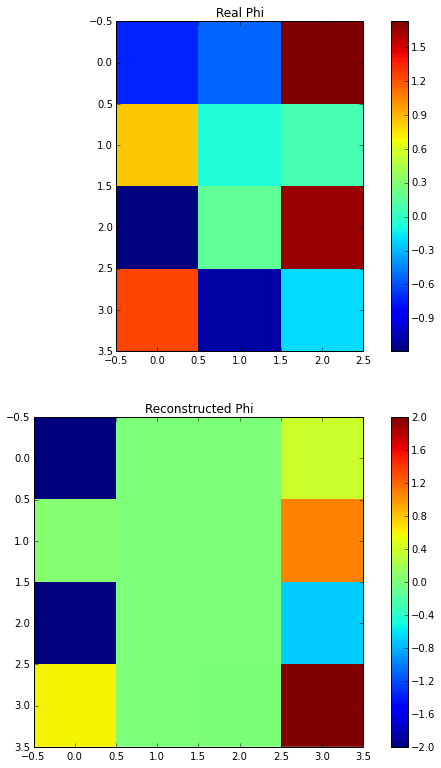

In [25]:
fig,axes = plt.subplots(nrows=2,ncols = 1,figsize=(10,13))
im = axes[0].imshow(phi, interpolation="None")
plt.colorbar(im,ax=axes[0])
axes[0].set_title('Real Phi')
#axes[0].scatter(n,np.zeros(n.size))
im = axes[1].imshow(phiHatExp, interpolation = "None",vmin=-2.0,vmax = 2.0)
plt.colorbar(im,ax=axes[1])
axes[1].set_title('Reconstructed Phi')
#plt.colorbar(fig)

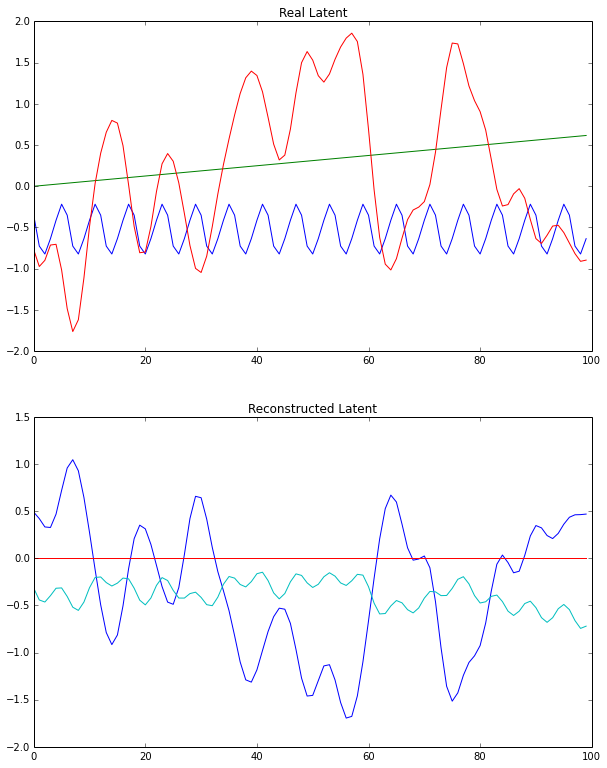

In [26]:
fig,axes = plt.subplots(nrows=2,ncols = 1,figsize=(10,13))
axes[0].plot(u.T)
axes[0].set_title('Real Latent')
#axes[0].scatter(n,np.zeros(n.size))
axes[1].plot(uExp.T)
axes[1].set_title('Reconstructed Latent')

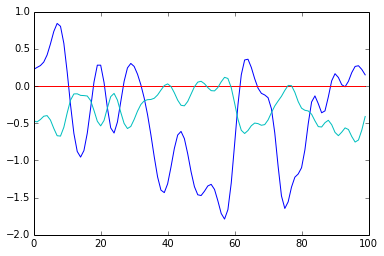

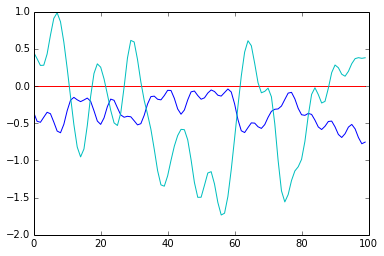

In [35]:
plt.plot(slfm.uExp.T)
plt.show()
plt.plot(uExp.T)

In [36]:
uVar[0]

matrix([[  1.75474405e+15,   2.78137135e+07,  -5.05194029e+07, ...,
          -8.36287449e+15,   7.51709241e+06,  -5.39694611e+06],
        [  2.78137134e+07,   9.65683253e+01,  -1.13942305e+02, ...,
          -1.78419633e+07,   9.38896555e-03,  -6.47162916e-03],
        [ -5.05194030e+07,  -1.13942305e+02,   1.69371195e+02, ...,
           3.30676081e+07,  -1.67518043e-02,   1.17063418e-02],
        ..., 
        [ -8.36285027e+15,  -1.78418630e+07,   3.30673953e+07, ...,
           3.21922749e+17,  -4.20439106e+08,   3.04186147e+08],
        [  7.51702902e+06,   9.38874113e-03,  -1.67513280e-02, ...,
          -4.20438407e+08,   2.91021136e+01,  -1.31125553e+01],
        [ -5.39690674e+06,  -6.47148533e-03,   1.17060379e-02, ...,
           3.04185693e+08,  -1.31125553e+01,   1.52794483e+01]])

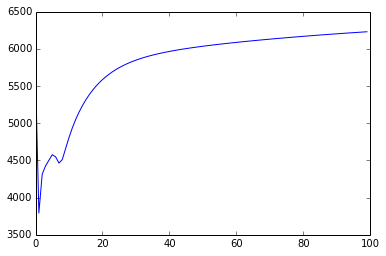

In [27]:
plt.plot(likelihoods*np.ones(len(likelihoods))*(-1))

#### Here we see that even though RBF kernel is used in the prior gusesses it is able to figure out the linear and periodic structure in the data